<a href="https://colab.research.google.com/github/waterfogSW/cover_set/blob/master/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [75]:
def parse_csv(path : str):
    scp_df = pd.read_csv(path)
    scp_df = scp_df.rename(columns={'X0':'X'})
    scp_df = scp_df.rename(columns={'X1':'Y'})
    return scp_df

In [76]:
df = parse_csv("./scp_data.csv")
df.head()

,X,Y
0,-6.810625,-0.060347
1,-0.303414,-2.979659
2,-7.891267,-11.736160
3,4.327531,2.606615
4,-9.171777,-6.358040


In [77]:
# normalize data
loc = df.values
sc = StandardScaler()
sc.fit(loc)
loc = sc.transform(loc)

In [91]:
def kmeans(loc,k=3,max_iterations=100):
    '''
    loc: Police office location data
    k: number of clusters
    max_iterations: number of repetitions before clusters are established
    '''
    if isinstance(loc, pd.DataFrame):loc = loc.values
    idx = np.random.choice(len(loc), k, replace=False)
    centroids = loc[idx, :]
    P = np.argmin(distance.cdist(loc, centroids, 'euclidean'),axis=1)
    for _ in range(max_iterations):
        centroids = np.vstack([loc[P==i,:].mean(axis=0) for i in range(k)])
        tmp = np.argmin(distance.cdist(loc, centroids, 'euclidean'),axis=1)
        if np.array_equal(P,tmp):break
        P = tmp
    return P

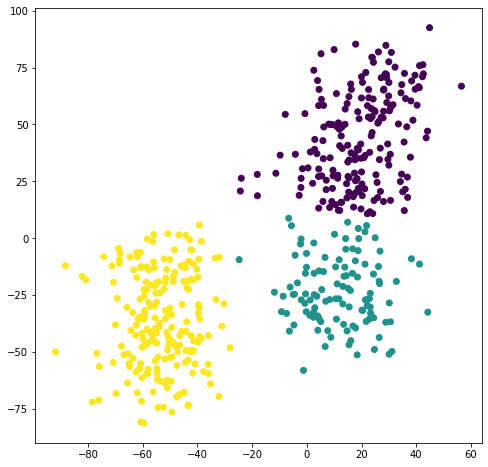

In [103]:
cluster_num = 3
P = kmeans(loc,cluster_num)

assert len(df) == len(P)
# denormalize data
loc = sc.inverse_transform(X)
plt.subplots(figsize=(8, 8))
plt.scatter(X[:,0],X[:,1],c=P)
plt.show()

In [104]:
cluster = pd.DataFrame(P, columns = ['cluster'])
df['cluster'] = cluster
df.head()

,X,Y,cluster
0,-6.810625,-0.060347,2
1,-0.303414,-2.979659,1
2,-7.891267,-11.736160,2
3,4.327531,2.606615,0
4,-9.171777,-6.358040,2


In [105]:
groups = df.groupby(df.cluster)
df_arr = []
for i in range(0, cluster_num):
    df_arr.append(groups.get_group(i))
 

In [106]:
df_arr[0]

,X,Y,cluster
3,4.327531,2.606615,0
10,3.216673,13.198100,0
12,3.165740,5.711748,0
13,1.588383,7.781952,0
14,2.131114,4.112230,0
...,...,...,...
481,3.208341,3.937154,0
482,3.092391,2.155256,0
483,4.442233,4.345441,0
485,3.302220,4.085139,0
